<div style="background-color:	#41e5d3; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">ML - Verhuuraantallen voorspellen - Heethoofd</h1>
<b style="color:white">Jasper Duncker, Julia Boschman, Nima Agha Ghafar Hamedani</b>
    </div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# metrics etc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
pd.options.display.max_columns = 500

### Bestanden importeren

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
sarima_train = train.copy()
sarima_test = test.copy()


## Opdracht 1: EDA

##### Toon datatypes en basisstatistieken

In [4]:
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [6]:
train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [7]:
train.isna().sum()

date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Voor het bestand train hebben we gekeken of het voldoet aan alle voorwaardes om een machine learning model te maken:

1. Het is een DataFrame
2. Het DataFrame heeft geen missende waardes
3. Het DataFrame had één kolom die geen numerieke waardes had en die is wordt omgezet naar een datetime kolom. Deze wordt ook gebruikt om nieuwe (numerieke) kolommen aan te maken.

Dus het bestand voldoet aan de voorwaardes.

In [8]:
test

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   456 non-null    object 
 1   holiday     456 non-null    int64  
 2   weathersit  456 non-null    int64  
 3   temp        456 non-null    float64
 4   atemp       456 non-null    float64
 5   hum         456 non-null    float64
 6   windspeed   456 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 25.1+ KB


In [10]:
test.describe()

,holiday,weathersit,temp,atemp,hum,windspeed
count,456.0,456.000000,456.000000,456.000000,456.000000,456.000000
mean,0.0,1.592105,0.360132,0.363691,0.714868,0.157639
std,0.0,0.607882,0.079432,0.076354,0.177732,0.106499
min,0.0,1.000000,0.160000,0.181800,0.330000,0.000000
25%,0.0,1.000000,0.300000,0.303000,0.560000,0.089600
50%,0.0,2.000000,0.360000,0.363600,0.750000,0.134300
75%,0.0,2.000000,0.400000,0.409100,0.870000,0.223900
max,0.0,3.000000,0.600000,0.621200,1.000000,0.492500


In [11]:
test.isna().sum()

date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

Net als bij het bestand train hebben wij gekeken naar de inhoud van het test bestand. Omdat wij deze gebruiken om uiteindelijk ons model mee te testen willen wij dit in de zelfde vorm hebben staan als het train bestand. Zo gaan wij ook in dit bestand de date_hour kolom omzetten naar een datetime en de kolom wordt gebruikt om verschillende kolommen met numerieke waardes aan te maken. Verder voldoet het ook aan alle voorwaardes:

1. Het is een DataFrame.
2. Het DataFrame heeft geen missende waardes.
3. Het DataFrame heeft alleen numerieke waardes.

##### Voeg tijdserie elementen toe en gebruik passende visualisaties om patronen zichtbaar te maken.

In [12]:
import pandas as pd
train['date_hour'] = pd.to_datetime(train['date_hour'])

# Voeg dag, week, maand, jaar
train['hour_of_day'] = train['date_hour'].dt.hour #Het uur van de dag (0-23).
train['day_of_week'] = train['date_hour'].dt.dayofweek #De dag van de week (maandag is 0, zondag is 6).
train['week'] = train['date_hour'].dt.isocalendar().week #De weken
train['month'] = train['date_hour'].dt.month
train['year'] = train['date_hour'].dt.year
train["day"] = train["date_hour"].dt.day

#Time series / date functionality — pandas 2.1.1 documentation. (n.d.). https://pandas.pydata.org/docs/user_guide/timeseries.html

def get_season(month):
    if month in [3, 4, 5]:  
        return 1
    elif month in [6, 7, 8]:  
        return 2
    elif month in [9, 10, 11]:
        return 3
    else: 
        return 4

train['season'] = train['month'].apply(get_season)

Wij maken voor onze train dataset een aantal nieuwe kolommen aan. Er zit een kolom in de dataset genaamd "date_hour". In deze kolom staan tijdspunten van iedere dag en ieder uur van de dagen tussen 01-01-2011 en 30-11-2012. Deze kolom hebben wij gebruikt om specifiekere tijdsgebonden kolommen te maken. Zo hebben wij de kolom gebruikt om de volgende waardes toe te voegen aan onze dataset:
- het uur van de dag 
- de dag van de week
- de week van het jaar
- de maand
- het jaar
- de dag van de maand 

Met deze data kunnen wij een EDA uitvoeren en onderzoeken welke waardes voor ons goed helpen bij het voorspellen van het aantal gehuurde producten per dag.

In [13]:
import pandas as pd
test['date_hour'] = pd.to_datetime(test['date_hour'])

test['hour_of_day'] = test['date_hour'].dt.hour #Het uur van de dag (0-23).
test['day_of_week'] = test['date_hour'].dt.dayofweek #De dag van de week (maandag is 0, zondag is 6).
test['week'] = test['date_hour'].dt.isocalendar().week #De weken
test['month'] = test['date_hour'].dt.month
test['year'] = test['date_hour'].dt.year

def get_season(month):
    if month in [3, 4, 5]:  
        return 1
    elif month in [6, 7, 8]:  
        return 2
    elif month in [9, 10, 11]:
        return 3
    else: 
        return 4

test['season'] = test['month'].apply(get_season)

De twee dataframes moeten in de zelfde vorm staan dus daarom passen wij op de test set de zelfde veranderingen toe als op de train set.

##### Visualisatie 1

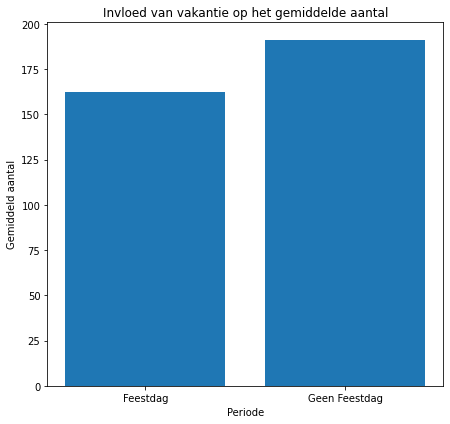

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

holiday_data = train[train['holiday'] == 1]
non_holiday_data = train[train['holiday'] == 0]
holiday_avg = holiday_data['cnt'].mean()
non_holiday_avg = non_holiday_data['cnt'].mean()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(['Feestdag', 'Geen Feestdag'], [holiday_avg, non_holiday_avg])
plt.xlabel('Periode')
plt.ylabel('Gemiddeld aantal')
plt.title('Invloed van vakantie op het gemiddelde aantal')


plt.tight_layout()
plt.show()

### Bevindingen feestdagen

We zien hier dat er gemiddeld minder van het product gebruikt wordt tijdeseen feestdagen.

##### Visualisatie 2

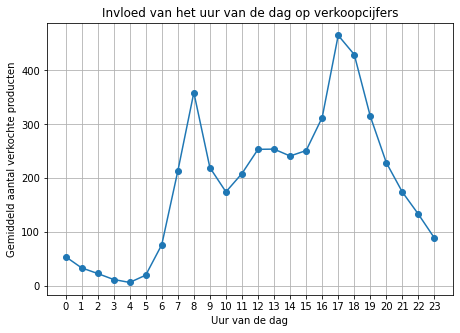

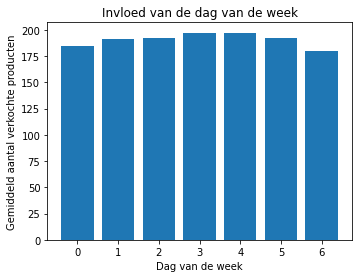

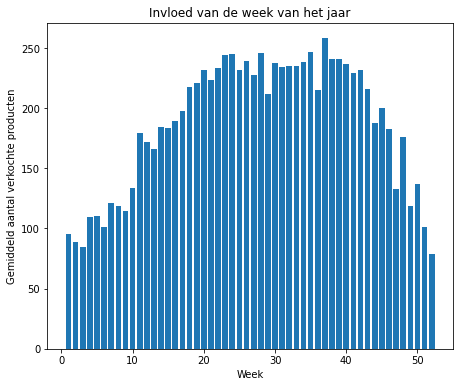

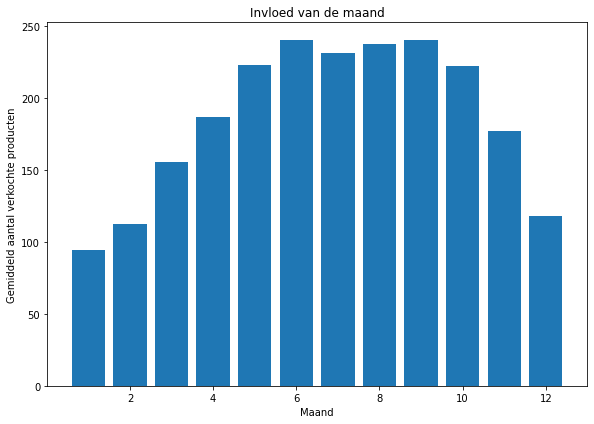

In [15]:
# Invloed van het uur van de dag op verkoopcijfers
hourly_avg = train.groupby('hour_of_day')['cnt'].mean()
plt.figure(figsize=(16, 5))
plt.subplot(122)
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel('Uur van de dag')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van het uur van de dag op verkoopcijfers')
plt.xticks(range(24))
plt.grid(True)

# Invloed van de dag van de week op de verkoop

day_of_week_avg = train.groupby('day_of_week')['cnt'].mean()
plt.figure(figsize=(12, 4))
plt.subplot(122)
plt.bar(day_of_week_avg.index, day_of_week_avg.values)
plt.xlabel('Dag van de week')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de dag van de week')

# Invloed van de week op de verkoop
plt.figure(figsize=(16, 6))

weekday_avg = train.groupby('week')['cnt'].mean()
plt.subplot(122)
plt.bar(weekday_avg.index, weekday_avg.values)
plt.xlabel('Week')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de week van het jaar')

# Invloed van de maand op de verkoop
plt.figure(figsize=(16, 6))

month_avg = train.groupby('month')['cnt'].mean()
plt.subplot(122)
plt.bar(month_avg.index, month_avg.values)
plt.xlabel('Maand')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de maand')

plt.tight_layout()
plt.show()

### Conclusie uur, dag, week, maand

#### Conclusie uur

Wij zien in deze plot dat er 2 pieken vallen. Dat is om 8 uur en om 17 uur. Deze uren vallen ook in de spitsuren. Door deze bevinding kan het product een relatie hebben met vervoer. (DPG Media Privacy Gate, n.d.)

DPG Media Privacy Gate. (n.d.). https://myprivacy.dpgmedia.nl/consent?siteKey=ujm6mv0jrqiz5syr&callbackUrl=https%3A%2F%2Fwww.autoweek.nl%2Fprivacygate-confirm%3FredirectUri%3D%252Fverkeer%252Fzo-vermijd-je-files-en-druk-verkeer-tijdens-de-spits%252F%253Freferrer%253Dhttps%25253A%25252F%25252Fwww.google.com%25252F

#### Conclusie dag

Wij zien dat er op zaterdag (5) en zondag (6) een kleine daling is tussen het gemiddeld gebruik van het product. Hiebij kan je concluderen dat het product te maken heeft met de werkdagen/schooldagen.

#### Conclusie week

We zien dat het bij het einde van de officiële zomervakantie er veel gebruikt van het product gebruikt wordt

#### Conclusie maand
We zien hierbij in de 'warmere maanden'Dat het product vaker gebruikt wordt. Hierdoor kunnen we zeggen dat het een product is dat vaak buiten gebruikt wordt.

##### Onderzoek de relatie tussen de onafhankelijke en de afhankelijke variabelen

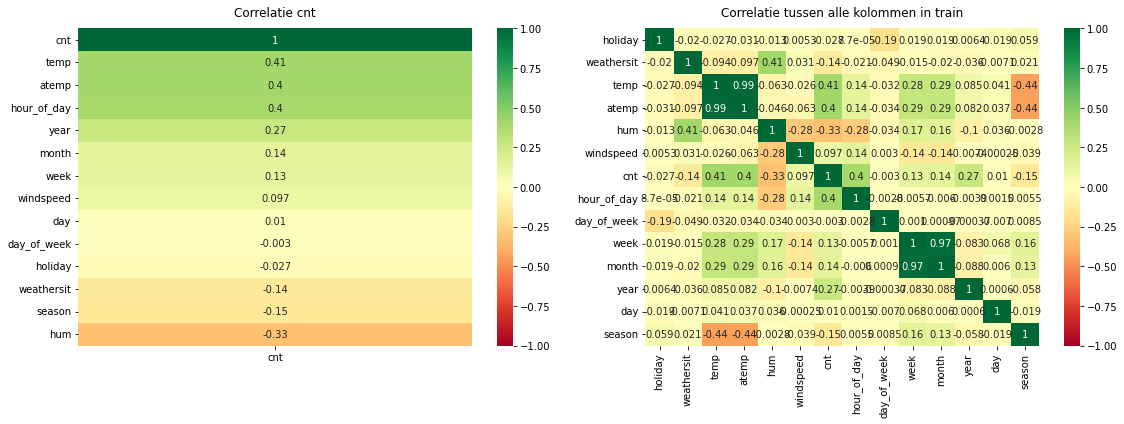

In [16]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(train.corr(method='pearson')[['cnt']].sort_values(by='cnt', ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie cnt', fontdict={'fontsize': 12}, pad=12)


plt.subplot(122) 
heatmap2 = sns.heatmap(train.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap2.set_title('Correlatie tussen alle kolommen in train', fontdict={'fontsize': 12}, pad=12)

plt.tight_layout()  
plt.show()

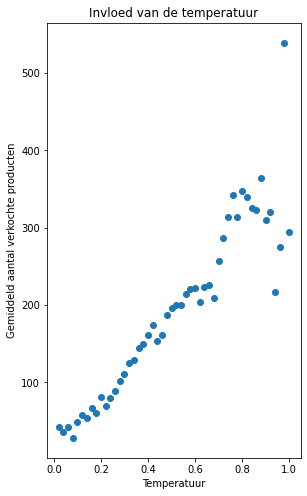

In [17]:
plt.figure(figsize=(10, 8))

temp_avg = train.groupby('temp')['cnt'].mean()
plt.subplot(122)
plt.scatter(temp_avg.index, temp_avg.values)
plt.xlabel('Temperatuur')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de temperatuur')
plt.show()

### Conclusie temperatuur
Uit deze visualisatie zien wij het volgende: Hoe warmer het weer, hoe vaker het product wordt gebruikt. Ook zien wij in de correlatie matrix de waardes die het meeste invloed hebben op het verhuren van het product. Dit zijn vrijwel allemaal waardes die te maken hebben met het weer.

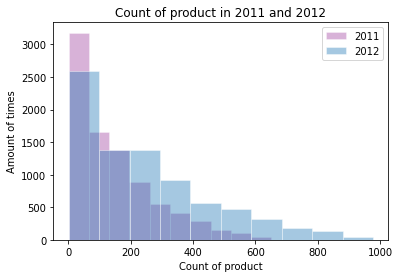

In [18]:
train['datum'] = train['date_hour'].dt.date

train2011 = train[train["year"] == 2011]
train2012 = train[train["year"] == 2012]

plt.hist(train2011["cnt"], alpha = 0.3, color = "purple", edgecolor = 'w', label= '2011')
plt.hist(train2012["cnt"], alpha = 0.4, edgecolor = 'w', label = '2012')
plt.xlabel("Count of product")
plt.ylabel("Amount of times")
plt.title("Count of product in 2011 and 2012")
plt.legend()
plt.show()

In [19]:
train["year"].value_counts()

2011    8645
2012    7992
Name: year, dtype: int64

In [20]:
print(train2011["datum"].min(), ",", train2011["datum"].max())

2011-01-01 , 2011-12-31


In [21]:
print(train2012["datum"].min(), ",", train2012["datum"].max())

2012-01-01 , 2012-11-30


In [22]:
print(train2011["cnt"].max())

651


In [23]:
print(train2012["cnt"].max())

977


Het valt ons op dat de data niet helemaal volledig is. Zo zien wij dat er meer datapunten zijn voor het jaar 2011 dan het jaar 2012. Wanneer wij dit verder onderzoeken zien wij dat de maand december ontbreekt in het jaar 2012. Dat komt, omdat wij de eerste drie weken van deze maand gaan voorspellen. Wel zien wij aan de visualisatie dat de waardes van 2012 een stuk hoger liggen. Zo zie je in de visualisatie dat in het jaar 2012 waardes liggen tot 977. In 2011 zijn er wel meerdere waarde, maar die liggen een stuk lager. Zo gaat het maximale punt tot 651. Dit is een verschil van meer dan 300.

C:\Users\Jaspe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


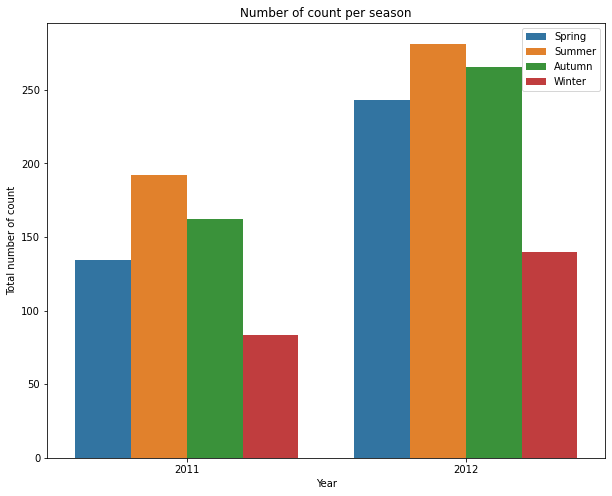

In [24]:
plt.figure(figsize=(10, 8))

# Invloed van het seizoen op de verkoop.
sns.barplot('year', "cnt",hue='season', data=train, ci=None)
plt.legend(["Spring", "Summer", "Autumn", "Winter"])
plt.xlabel('Year')
plt.ylabel('Total number of count')
plt.title('Number of count per season')
plt.show()

### Conclusie per seizoen
Wij zien dat er in de lente, zomer en herfst meer mensen hebben besloten op het product te gebruiken dan in de winter. Hieruit kan je de hypothese stellen dat het een product is die je buiten gebruikt. Vooral omdat het product het meeste wordt gebruikt in de zomer wanneer het ook buiten lekkerder weer is.

C:\Users\Jaspe\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


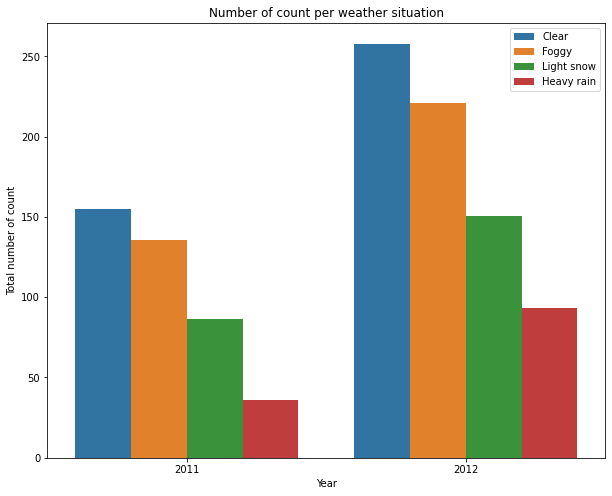

In [25]:
plt.figure(figsize=(10, 8))
# Invloed van de weersituatie op de verkoop.
sns.barplot('year', "cnt",hue='weathersit', data=train, ci=None)
plt.legend(['Clear', 'Foggy', 'Light snow', 'Heavy rain'])
plt.xlabel('Year')
plt.ylabel('Total number of count')
plt.title('Number of count per weather situation')
plt.show()

### Conclusie per weer situatie
Wij zien dat hoe aantrekkelijker het weer is om naar buiten te gaan, hoe meer er van het product gebruikt wordt. Hieruit kan je de hypothese stellen dat het een product is die je buiten gebruikt. Vooral wanneer het droog is buiten.

### Conclusie EDA

Wij zien dan het product vaker gebruikt wordt:

- Bij rustige weeromstandigheden ("clear")
    - Hierdoor verwachten wij dat het product voor buiten is
- Bij Warm weer
    - Hierdoor verwachten wij dat het product voor buiten is
- Tijdens de spitsuren
     - Hierdoor verwachten wij dat het een vervoersmiddel is.
     
Door deze conclusies samen te voegen zouden dit voertuigen op twee wielen kunnen zijn (fietsen, scooters, etc)

In [26]:
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour_of_day,day_of_week,week,month,year,day,season,datum
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,52,1,2011,1,4,2011-01-01
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,52,1,2011,1,4,2011-01-01
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,52,1,2011,1,4,2011-01-01
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,52,1,2011,1,4,2011-01-01
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,52,1,2011,1,4,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,48,11,2012,30,3,2012-11-30
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,48,11,2012,30,3,2012-11-30
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,48,11,2012,30,3,2012-11-30
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,48,11,2012,30,3,2012-11-30


In [27]:
test

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour_of_day,day_of_week,week,month,year,season
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,48,12,2012,4
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,48,12,2012,4
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,48,12,2012,4
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,48,12,2012,4
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,48,12,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,2,51,12,2012,4
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,2,51,12,2012,4
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,2,51,12,2012,4
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896,22,2,51,12,2012,4


Wij geven na de EDA duidelijk weer hoe onze twee datasets er nu uit zien. Hier zie je de toegevoegde kolommen die gebruikt zijn om visualisaties mee te maken en worden hieronder gebruikt om onze modellen mee te trainen.

### Metric Functie

In [28]:
def train_test_model(model):
    """
    Traint het opgegeven model met behulp van de meegeleverde trainingsgegevens en evalueert het met de testgegevens.

    Parameters:
    ----------
    model : model vergelijkbaar met sklearn
        Het model dat getraind en geëvalueerd moet worden.
    
    Returns:
    -------
    RMSE :
        Deze functie drukt de RMSE score van het model op de testgegevens af.
    
        
    """

    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = MSE**0.5
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    return print('R2:',R2,
                 '\nMAE:', MAE,
                 '\nMSE:',MSE,
                 '\nRMSE:',RMSE)

Hierboven hebben wij een functie aangemaakt die onze modellen traint, voorspelt en alle nuttige waardes laat zien. Dit scheelt ons erg in tijd wanneer wij gaan modelleren, omdat wij zo niet iedere keer alle stappen hoeven te doorlopen.

### TimeSeries

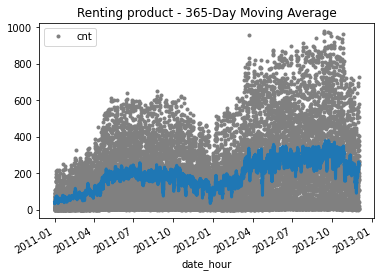

In [29]:
roll_train = train[["date_hour", "cnt"]].set_index("date_hour")

moving_average = roll_train.rolling(
    window=52,
    center=True,
    min_periods=26,
).mean()

ax = roll_train.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Renting product - 365-Day Moving Average", legend=False,
);

<AxesSubplot: xlabel='date_hour'>

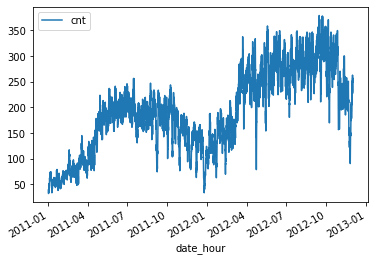

In [30]:
moving_average.plot()

Wij zien in de moving averages dat er een duidelijk patroon is. Zo zie je dat het product een sterke piek heeft tijdens de zomer maanden en een drastische daling heeft richting de winter maanden. Deze bevinding hadden wij ook eerder gemaakt in onze EDA.

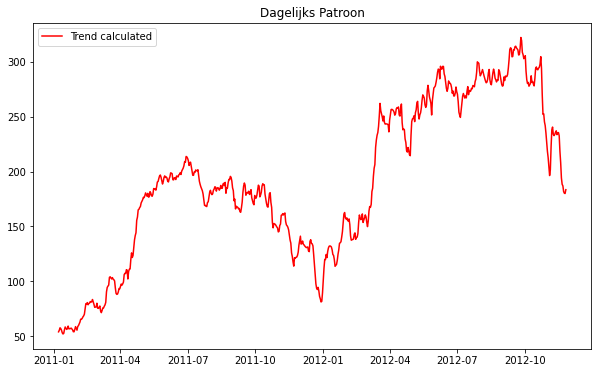

In [31]:
train['datum'] = train['date_hour'].dt.date

nieuw_dataframe = train[['datum', 'cnt']]
nieuw_dataframe.set_index('datum', inplace=True)
nieuw_dataframe.index = pd.to_datetime(nieuw_dataframe.index)

dagelijks_resampled = nieuw_dataframe.resample('D').mean()
weekly_resampled = nieuw_dataframe.resample('W').mean()

#pandas.DataFrame.resample — pandas 2.1.2 documentation. (n.d.). #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

def calculate_trend(df, window_size):
    """
    Calculates the trend component using a rolling window and moving averages

    Parameters:
        df (pandas.DataFrame): DataFrame with a DateTime index and a single column.
        window_size: The length of the rolling window in units of time
    """
    trend = df.rolling(window_size, center=True).mean()
    return trend

plt.figure(figsize=(10,6))

trend_calculated = calculate_trend(dagelijks_resampled, window_size=12)

plt.plot(trend_calculated, label="Trend calculated", color="red")

plt.title("Dagelijks Patroon")
plt.legend()
plt.show()

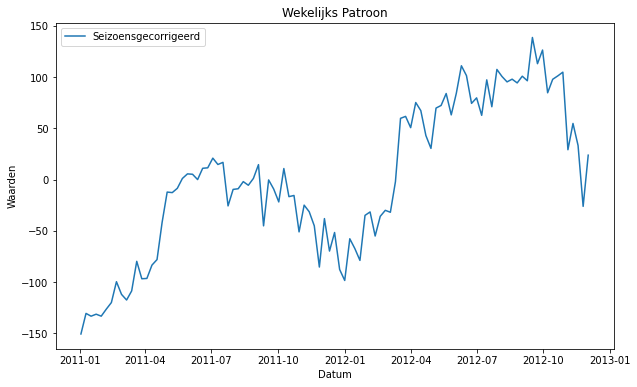

In [32]:
seasonal_pattern = weekly_resampled.groupby(weekly_resampled.index.dayofweek)['cnt'].mean()

weekly_resampled['seasonal_adjusted'] = weekly_resampled['cnt'] - weekly_resampled.index.dayofweek.map(seasonal_pattern)

plt.figure(figsize=(10, 6))


plt.plot(weekly_resampled.index, weekly_resampled['seasonal_adjusted'], label='Seizoensgecorrigeerd')
plt.xlabel('Datum')
plt.ylabel('Waarden')
plt.title('Wekelijks Patroon')
plt.legend()
plt.show()

Wij bekijken nog eens het patroon van de data. Hier is het gevisualiseerd met de waardes van de dagen, maar ook de weken. Zo zie je bij de eerste visualisatie een lijn met wat meer pieken. Wel is de vorm van de lijn het zelfde. Net als bij de visualisatie boven deze twee grafieken. In de zomer is er een piek en in de winter is er een duidelijke daling.

In [33]:
train2 = train.copy()
train2 = pd.DataFrame(train2.groupby("datum")["cnt"].sum())
train2

,cnt
datum,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-11-26,5087
2012-11-27,3959
2012-11-28,5260


Wij maken hier een dataframe aan met de waardes van het aantal gehuurde producten. Dit doen wij hier per dag in plaats van per uur. Zo kunnen wij makkelijk een visualisatie maken van den trend lijn, de seizoenscomponenten en de residuals.

In [34]:
import statsmodels.api as sm

def decompose_ts(series, period=None):
    decompose = sm.tsa.seasonal_decompose(series, period=period)
    trend = decompose.trend
    seasonal = decompose.seasonal
    resid = decompose.resid
    return trend, seasonal, resid

trend, seasonal, resid = decompose_ts(train2, period= 24)
print(trend, seasonal, resid)

datum
2011-01-01   NaN
2011-01-02   NaN
2011-01-03   NaN
2011-01-04   NaN
2011-01-05   NaN
              ..
2012-11-26   NaN
2012-11-27   NaN
2012-11-28   NaN
2012-11-29   NaN
2012-11-30   NaN
Name: trend, Length: 700, dtype: float64 datum
2011-01-01    220.650908
2011-01-02   -186.679449
2011-01-03   -188.228556
2011-01-04    -94.602068
2011-01-05    139.186622
                 ...    
2012-11-26    160.094360
2012-11-27    220.650908
2012-11-28   -186.679449
2012-11-29   -188.228556
2012-11-30    -94.602068
Name: seasonal, Length: 700, dtype: float64 datum
2011-01-01   NaN
2011-01-02   NaN
2011-01-03   NaN
2011-01-04   NaN
2011-01-05   NaN
              ..
2012-11-26   NaN
2012-11-27   NaN
2012-11-28   NaN
2012-11-29   NaN
2012-11-30   NaN
Name: resid, Length: 700, dtype: float64


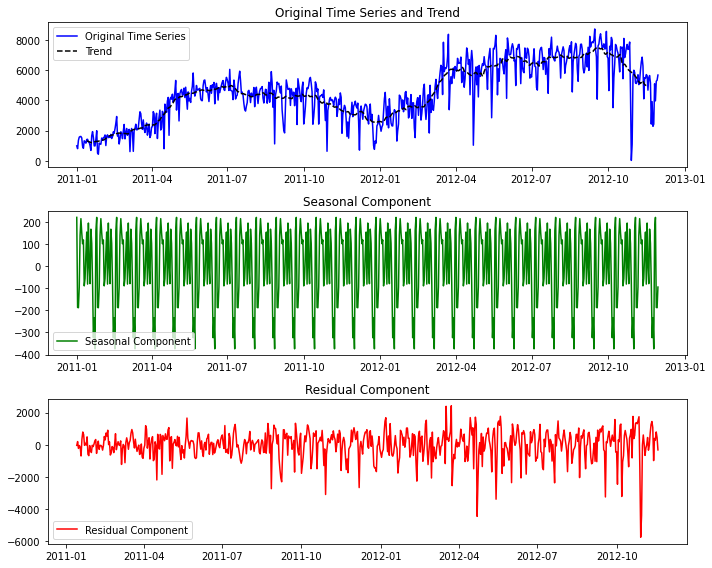

In [35]:
import matplotlib.pyplot as plt

def plot_ts(df, trend, seasonal, residuals):
    """
    Plots the original time series, trend, seasonal, and residual components.

    Parameters:
        df (pandas.DataFrame): DataFrame with a DateTime index and a single column.
        trend (pandas.Series): Time series representing the trend component.
        seasonal (pandas.Series): Time series representing the seasonal component.
        residuals (pandas.Series): Time series representing the residual component.
    """

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

    # Plot the original time series and trend
    axes[0].plot(df.index, df.iloc[:, 0], color='blue', label='Original Time Series')
    axes[0].plot(df.index, trend, color='black', linestyle='dashed', label='Trend')
    axes[0].set_title('Original Time Series and Trend')
    axes[0].legend()

    # Plot the seasonal component
    axes[1].plot(df.index, seasonal, color='green', label='Seasonal Component')
    axes[1].set_title('Seasonal Component')
    axes[1].legend()

    # Plot the residual component
    axes[2].plot(df.index, residuals, color='red', label='Residual Component')
    axes[2].set_title('Residual Component')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

plot_ts(train2, trend, seasonal, resid)

Wij zien in de visualisatie hierboven dat de trend lijn mooi loopt over onze dataset. Ook is er een mooie weergave van de seasonal components en de residuals. Wij gaan deze later in ons notebook gebruiken om te modelleren. Bijvoorbeeld bij het uitvoeren van het SARIMA(X) model.
- De code van deze visualisatie komt uit de eerste time series les.

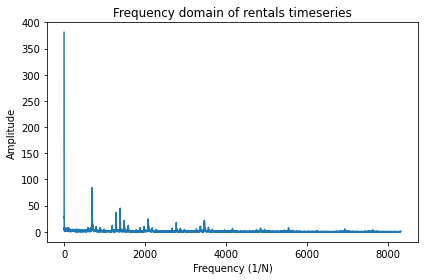

In [36]:
N = len(roll_train)

# Compute the Fourier transform of the timeseries
train_ft = np.fft.fft(roll_train['cnt'])

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(train_ft[:N//2])

# Plot the constituent frequencies
plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of rentals timeseries")

plt.tight_layout()
plt.show()

Peaks found at [   2  692  694 1387]


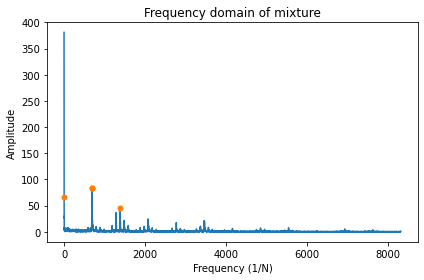

In [37]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(magnitude, height=45)

print(f"Peaks found at {peaks}")

plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of mixture")

plt.plot(peaks, magnitude[peaks], ".", markersize=10)

plt.tight_layout()
plt.show()

In de visualisaties hierboven gaan wij onderzoek doen naar de frequentie van onze data. Hoe is de data verdeeld en in welke tijdsperiode kunnen de beste voorspellingen maken? Dit kunnen wij berekenen door te kijken naar de pieken van de amplitude. De dominante frequenties bij onze gekozen magnitude (hoogte) zijn 2, 692, 694 en 1387. Hieronder onderzoeken wij wat deze waardes zeggen over onze data.

In [38]:
for peak in peaks:
    print(N/peak)

8318.5
24.041907514450866
23.972622478386167
11.994953136265321


Het valt ons op dat er een aantal dominante frequenties zijn. Wij hebben deze waardes omgerekend naar uren. Wij zien een duidelijk verband op het niveau van een jaar, een dag en een halve dag. Wij gaan een halve dag niet gebruiken, omdat deze waarde geen toevoeging heeft aan ons specifieke onderzoek.

In [39]:
test = test.set_index('date_hour')
test

,holiday,weathersit,temp,atemp,hum,windspeed,hour_of_day,day_of_week,week,month,year,season
date_hour,,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,48,12,2012,4
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,48,12,2012,4
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,48,12,2012,4
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,48,12,2012,4
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,48,12,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,2,51,12,2012,4
2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,2,51,12,2012,4
2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,2,51,12,2012,4


In [40]:
train = train.set_index('date_hour')
train

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour_of_day,day_of_week,week,month,year,day,season,datum
date_hour,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,52,1,2011,1,4,2011-01-01
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,52,1,2011,1,4,2011-01-01
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,52,1,2011,1,4,2011-01-01
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,52,1,2011,1,4,2011-01-01
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,52,1,2011,1,4,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,48,11,2012,30,3,2012-11-30
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,48,11,2012,30,3,2012-11-30
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,48,11,2012,30,3,2012-11-30


Wij maken hierboven van beide modellen een nieuwe index aan. Hier stellen wij de datetime kolom "date_hour" in als index. Deze kunnen wij nu gaan gebruiken om een Fourier analyse uit te voeren.

In [41]:
dfNew = pd.get_dummies(data = train, columns=['day_of_week','holiday'])
dfNew

,weathersit,temp,atemp,hum,windspeed,cnt,hour_of_day,week,month,year,day,season,datum,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
date_hour,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0000,16,0,52,1,2011,1,4,2011-01-01,0,0,0,0,0,1,0,1,0
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0000,40,1,52,1,2011,1,4,2011-01-01,0,0,0,0,0,1,0,1,0
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0000,32,2,52,1,2011,1,4,2011-01-01,0,0,0,0,0,1,0,1,0
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0000,13,3,52,1,2011,1,4,2011-01-01,0,0,0,0,0,1,0,1,0
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0000,1,4,52,1,2011,1,4,2011-01-01,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,1,0.32,0.3485,0.66,0.0000,377,19,48,11,2012,30,3,2012-11-30,0,0,0,0,1,0,0,1,0
2012-11-30 20:00:00,1,0.32,0.3485,0.66,0.0000,245,20,48,11,2012,30,3,2012-11-30,0,0,0,0,1,0,0,1,0
2012-11-30 21:00:00,1,0.30,0.3182,0.75,0.0896,183,21,48,11,2012,30,3,2012-11-30,0,0,0,0,1,0,0,1,0


De eerste keer dat wij het model hadden getraind op de data hadden wij ook dummie kolommen aangemaakt van de kolom "hour_of_day". Echter is dit het zelfde als de kolom met de sinus waar ook de uren van de dag worden gebruikt. Daarom hebben wij er later voor gekozen om deze kolom toch te laten hoe die is en hier geen dummie waardes van te maken. Dit hebben wij dus aangepast na het trainen van al onze modellen.

### Train, test, split

In [42]:
from sklearn.model_selection import train_test_split
X = dfNew.drop(['cnt','datum', 'day', 'holiday_1', 'week', 'month', 'year', 'season'],axis=1)
y = dfNew['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3*7*24, random_state=27, shuffle=False)

Wij doen hier een train en test split als voorbereiding op het maken van een Fourier analyse. Later gebruiken wij deze datasets ook om mee te modelleren. Er zijn een aantal belangrijke punten die wij mee hebben genomen in de parameters:
- test_size: Wij gebruiken hier een andere test_size dan wij normaal gewend zijn in een train en test split. Normaal zouden wij een split doen in een percentage. Bijvoorbeeld een split van 0.2 (20%) of 0.3 (30%). Voor deze modellen willen wij 3 weken vooruit kunnen voorspellen. Daarom willen wij ook een uiteindelijke test set hebben van 3 weken. Hiervoor stellen wij een handmatige test_size in waar wij het aantal regels pakken die gelijk staat aan 3 weken. Zo pakken wij een test_size van 3x7x24. De waardes staan voor:
 - 24 = de uren in een dag
 - 7 = de dagen in de week
 - 3 = het aantal weken
 
- shuffle: Ook doen wij nog iets met shuffle wat wij bij een andere dataset niet zouden doen. Bij het voorspellen van een dataset willen wij vaak de data door elkaar husselen, zodat wij een model maken die beter voorspelt op random data. Echter nu wij bezig zijn met het voorspellen van tijdgebonden data willen wij dit niet random selecteren. Het moet op volgorde staan zodat het naar de toekomst kan kijken. Dat is erg belangrijk bij het voorspellen van time series data.
 - Wij zetten de shuffle op False

In [43]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier1 = CalendarFourier(freq="A", order=1)  # 1 sin/cos pairs for "A"nnual seasonality
fourier2 = CalendarFourier(freq="D", order=1)  # 1 sin/cos pairs for "D"aily seasonality

dp = DeterministicProcess(
    index=y_train.index,
    constant=False,
    order=1,                     # trend (order 1 means linear)
    seasonal=False,
    additional_terms=[fourier1,fourier2],
    drop=True,
)

X_train2 = dp.in_sample()
X_test2 = dp.out_of_sample(steps=len(y_test.index),forecast_index= y_test.index)
X_train2

,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,
2011-01-01 00:00:00,1.0,0.000000,1.000000,0.000000,1.000000e+00
2011-01-01 01:00:00,2.0,0.000717,1.000000,0.258819,9.659258e-01
2011-01-01 02:00:00,3.0,0.001435,0.999999,0.500000,8.660254e-01
2011-01-01 03:00:00,4.0,0.002152,0.999998,0.707107,7.071068e-01
2011-01-01 04:00:00,5.0,0.002869,0.999996,0.866025,5.000000e-01
...,...,...,...,...,...
2012-11-09 18:00:00,16129.0,-0.781449,0.623969,-1.000000,-1.836970e-16
2012-11-09 19:00:00,16130.0,-0.781003,0.624528,-0.965926,2.588190e-01
2012-11-09 20:00:00,16131.0,-0.780556,0.625086,-0.866025,5.000000e-01


In de cel hierboven voeren wij een Fourier analyse uit. Wij hebben een paar cellen terug een analyse gedaan op de pieken van de frequentie. Hieruit hadden wij het besluit genomen om te kijken naar de periode van een jaar en de periode van dagen. Hier berekenen wij met de Fourier analyse de sin en cos van. Deze gebruiken wij later om onze modellen te trainen. We gebruiken ze hieronder om een visuele weergave te doen van de verdelingen.

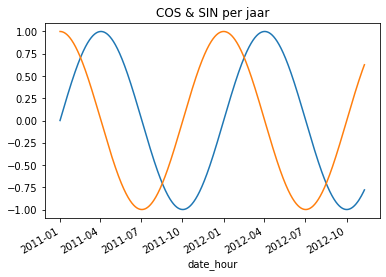

In [44]:
X_train2['sin(1,freq=A-DEC)'].plot()
X_train2['cos(1,freq=A-DEC)'].plot()
plt.title('COS & SIN per jaar')
plt.show()

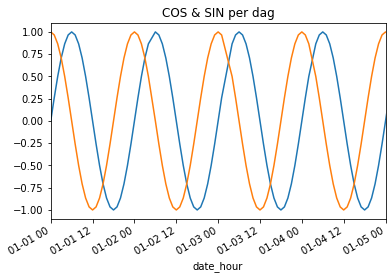

In [45]:
X_train2['sin(1,freq=D)'].plot()
X_train2['cos(1,freq=D)'].plot()
plt.xlim('2011-01-01','2011-01-05')
plt.title("COS & SIN per dag")
plt.show()

Wij zien in de grafieken hierboven de sin en cos weergegeven van de jaren en de dagen. Hierin zie je dat een periode loopt van 1.00 tot 1.00. Dus tussen de pieken van de lijnen.

(-0.25, 0.25)

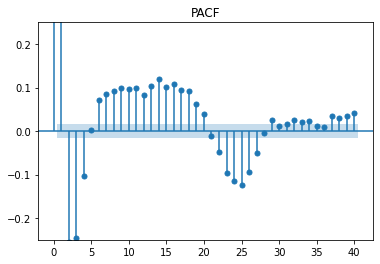

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train["temp"], lags = 40, method = "ywm")
plt.title("PACF")
plt.ylim([-0.25, 0.25])

Wij zien in de visualisatie hierboven dat het 6e punt in het blauwe gebied valt. Dit wilt zeggen dat wij voor ons onderzoek gebruik gaan maken van 5 lags. Wij gebruiken deze om een goede voorspelling te maken. Zo staan alle punten buiten het blauwe gebied voor de lags die een goede voorspelling kunnen maken. Het blauwe gebied is het gebied buiten het betrouwbaarheidsinterval. Alles hier buiten maakt volgens de Partial Auto Correlation Funtion goede voorspellingen. Wij kiezen voor temperatuur, omdat dit een kolom is die volgens ons veel invloed heeft op het verhuren van het product. Ook hebben wij na het trainen andere waardes gebruikt voor de lags. Zo hebben wij gekeken of onze modellen beter presteren met de lags voor "humidity" of "atemp" (gevoelstemperatuur). Dit was echter niet het geval. Daarom hebben wij de lags toch terug gezet naar de temperatuur.

In [47]:
def make_lags(ts, lags, lead_time=1):
    """
    Creates a DataFrame with lagged versions of a time series.

    Parameters:
    - ts (pd.Series): The time series for which lagged versions are to be created.
    - lags (int): The number of lagged versions to be created.
    - lead_time (int, optional): The number of steps by which the time series is forward-shifted (default is 1).

    Returns:
    pd.DataFrame: A DataFrame with lagged versions of the time series, where each column is labeled as 'y_lag_i',
    where 'i' is the number of steps by which the time series is lagged.
    """
    return pd.concat(
        {f'y_lag_{i}': ts.shift(i) for i in range(0, lags + lead_time)},
        axis=1
    )

df_lags = make_lags(X_train['temp'], lags=5)
df_lags = df_lags.fillna(0.0)
df_lags

,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
date_hour,,,,,,
2011-01-01 00:00:00,0.24,0.00,0.00,0.00,0.00,0.00
2011-01-01 01:00:00,0.22,0.24,0.00,0.00,0.00,0.00
2011-01-01 02:00:00,0.22,0.22,0.24,0.00,0.00,0.00
2011-01-01 03:00:00,0.24,0.22,0.22,0.24,0.00,0.00
2011-01-01 04:00:00,0.24,0.24,0.22,0.22,0.24,0.00
...,...,...,...,...,...,...
2012-11-09 18:00:00,0.42,0.42,0.46,0.46,0.46,0.46
2012-11-09 19:00:00,0.34,0.42,0.42,0.46,0.46,0.46
2012-11-09 20:00:00,0.36,0.34,0.42,0.42,0.46,0.46


Nu is het tijd om alle kolommen die wij willen gebruiken bij het modelleren als één dataset samen te voegen.

In [48]:
X_train = pd.concat([X_train, X_train2], axis = 1)
X_train

,weathersit,temp,atemp,hum,windspeed,hour_of_day,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0000,0,0,0,0,0,0,1,0,1,1.0,0.000000,1.000000,0.000000,1.000000e+00
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0000,1,0,0,0,0,0,1,0,1,2.0,0.000717,1.000000,0.258819,9.659258e-01
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0000,2,0,0,0,0,0,1,0,1,3.0,0.001435,0.999999,0.500000,8.660254e-01
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0000,3,0,0,0,0,0,1,0,1,4.0,0.002152,0.999998,0.707107,7.071068e-01
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0000,4,0,0,0,0,0,1,0,1,5.0,0.002869,0.999996,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-09 18:00:00,1,0.42,0.4242,0.44,0.1045,18,0,0,0,0,1,0,0,1,16129.0,-0.781449,0.623969,-1.000000,-1.836970e-16
2012-11-09 19:00:00,1,0.34,0.3485,0.71,0.0896,19,0,0,0,0,1,0,0,1,16130.0,-0.781003,0.624528,-0.965926,2.588190e-01
2012-11-09 20:00:00,1,0.36,0.3485,0.66,0.1343,20,0,0,0,0,1,0,0,1,16131.0,-0.780556,0.625086,-0.866025,5.000000e-01


In [49]:
X_train = pd.concat([X_train, df_lags], axis = 1)
X_train

,weathersit,temp,atemp,hum,windspeed,hour_of_day,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)",y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
date_hour,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0000,0,0,0,0,0,0,1,0,1,1.0,0.000000,1.000000,0.000000,1.000000e+00,0.24,0.00,0.00,0.00,0.00,0.00
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0000,1,0,0,0,0,0,1,0,1,2.0,0.000717,1.000000,0.258819,9.659258e-01,0.22,0.24,0.00,0.00,0.00,0.00
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0000,2,0,0,0,0,0,1,0,1,3.0,0.001435,0.999999,0.500000,8.660254e-01,0.22,0.22,0.24,0.00,0.00,0.00
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0000,3,0,0,0,0,0,1,0,1,4.0,0.002152,0.999998,0.707107,7.071068e-01,0.24,0.22,0.22,0.24,0.00,0.00
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0000,4,0,0,0,0,0,1,0,1,5.0,0.002869,0.999996,0.866025,5.000000e-01,0.24,0.24,0.22,0.22,0.24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-09 18:00:00,1,0.42,0.4242,0.44,0.1045,18,0,0,0,0,1,0,0,1,16129.0,-0.781449,0.623969,-1.000000,-1.836970e-16,0.42,0.42,0.46,0.46,0.46,0.46
2012-11-09 19:00:00,1,0.34,0.3485,0.71,0.0896,19,0,0,0,0,1,0,0,1,16130.0,-0.781003,0.624528,-0.965926,2.588190e-01,0.34,0.42,0.42,0.46,0.46,0.46
2012-11-09 20:00:00,1,0.36,0.3485,0.66,0.1343,20,0,0,0,0,1,0,0,1,16131.0,-0.780556,0.625086,-0.866025,5.000000e-01,0.36,0.34,0.42,0.42,0.46,0.46


Als laatste voegen wij ook nog de lags toe aan ons model. Wij hebben deze eerst uit onze dataset gelaten tijdens het trainen van de modellen. Hier zijn wij er echter achter gekomen dat onze modellen beter voorspellingen maken wanneer de lags wel worden meegenomen tijdens het trainen.

In [50]:
df_lags2 = make_lags(X_test['temp'], lags=5)
df_lags2 = df_lags2.fillna(0.0)
df_lags2

,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
date_hour,,,,,,
2012-11-09 23:00:00,0.32,0.00,0.00,0.00,0.00,0.00
2012-11-10 00:00:00,0.32,0.32,0.00,0.00,0.00,0.00
2012-11-10 01:00:00,0.30,0.32,0.32,0.00,0.00,0.00
2012-11-10 02:00:00,0.32,0.30,0.32,0.32,0.00,0.00
2012-11-10 03:00:00,0.30,0.32,0.30,0.32,0.32,0.00
...,...,...,...,...,...,...
2012-11-30 19:00:00,0.32,0.34,0.36,0.40,0.42,0.40
2012-11-30 20:00:00,0.32,0.32,0.34,0.36,0.40,0.42
2012-11-30 21:00:00,0.30,0.32,0.32,0.34,0.36,0.40


In [51]:
X_test = pd.concat([X_test, X_test2], axis = 1)
X_test = pd.concat([X_test, df_lags2], axis = 1)
X_test

,weathersit,temp,atemp,hum,windspeed,hour_of_day,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)",y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
date_hour,,,,,,,,,,,,,,,,,,,,,,,,,
2012-11-09 23:00:00,1,0.32,0.3333,0.81,0.0896,23,0,0,0,0,1,0,0,1,16134.0,-0.779212,0.626760,-0.258819,0.965926,0.32,0.00,0.00,0.00,0.00,0.00
2012-11-10 00:00:00,1,0.32,0.3333,0.76,0.0896,0,0,0,0,0,0,1,0,1,16135.0,-0.778764,0.627317,0.000000,1.000000,0.32,0.32,0.00,0.00,0.00,0.00
2012-11-10 01:00:00,1,0.30,0.3182,0.81,0.0896,1,0,0,0,0,0,1,0,1,16136.0,-0.778315,0.627874,0.258819,0.965926,0.30,0.32,0.32,0.00,0.00,0.00
2012-11-10 02:00:00,1,0.32,0.3485,0.81,0.0000,2,0,0,0,0,0,1,0,1,16137.0,-0.777866,0.628431,0.500000,0.866025,0.32,0.30,0.32,0.32,0.00,0.00
2012-11-10 03:00:00,1,0.30,0.3333,0.81,0.0000,3,0,0,0,0,0,1,0,1,16138.0,-0.777416,0.628987,0.707107,0.707107,0.30,0.32,0.30,0.32,0.32,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,1,0.32,0.3485,0.66,0.0000,19,0,0,0,0,1,0,0,1,16633.0,-0.510494,0.859881,-0.965926,0.258819,0.32,0.34,0.36,0.40,0.42,0.40
2012-11-30 20:00:00,1,0.32,0.3485,0.66,0.0000,20,0,0,0,0,1,0,0,1,16634.0,-0.509879,0.860246,-0.866025,0.500000,0.32,0.32,0.34,0.36,0.40,0.42
2012-11-30 21:00:00,1,0.30,0.3182,0.75,0.0896,21,0,0,0,0,1,0,0,1,16635.0,-0.509263,0.860611,-0.707107,0.707107,0.30,0.32,0.32,0.34,0.36,0.40


Wat wij net hebben gedaan voor X_train doen wij ook bij X_test. Zo kunnen we beide dataframes gebruiken om ons model mee te trainen.

### Maken van testset

Nu wij de train set klaar hebben om mee te modelleren vinden wij het belangrijk om nu meteen onze test set aan te passen naar de zelfde kolommen. Zo weten wij nog precies hoe onze train data er uit ziet en kunnen wij het mooi gelijk maken.

In [52]:
df_test = pd.get_dummies(data = test, columns=['day_of_week','holiday'])
df_test = df_test.drop(['week', 'month', 'year', 'season'],axis=1)

In [53]:
df_test2 = dp.out_of_sample(steps=len(df_test.index),forecast_index= df_test.index)
df_test2

,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,
2012-12-01 00:00:00,16134.0,-0.507415,0.861702,0.000000,1.000000
2012-12-01 01:00:00,16135.0,-0.506799,0.862064,0.258819,0.965926
2012-12-01 02:00:00,16136.0,-0.506182,0.862427,0.500000,0.866025
2012-12-01 03:00:00,16137.0,-0.505565,0.862789,0.707107,0.707107
2012-12-01 04:00:00,16138.0,-0.504948,0.863150,0.866025,0.500000
...,...,...,...,...,...
2012-12-19 19:00:00,16585.0,-0.208052,0.978118,-0.965926,0.258819
2012-12-19 20:00:00,16586.0,-0.207352,0.978266,-0.866025,0.500000
2012-12-19 21:00:00,16587.0,-0.206652,0.978414,-0.707107,0.707107


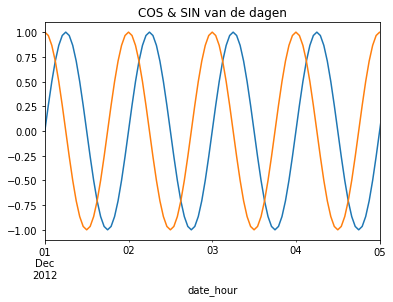

In [54]:
df_test2['sin(1,freq=D)'].plot()
df_test2['cos(1,freq=D)'].plot()
plt.xlim('2012-12-01','2012-12-05')
plt.title("COS & SIN van de dagen")
plt.show()

Net als bij de visualisaties van de train set laat de cel hierboven zien dat dat de test set is ingedeeld per dag. Voor de test set kan alleen de verdeling van de dag worden weergegeven, omdat er data in staat van alleen december. Hier kunnen dus geen maanden worden meegenomen.

In [55]:
df_lags_test = make_lags(df_test['temp'], lags=5)
df_lags_test = df_lags_test.fillna(0.0)
df_lags_test

,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
date_hour,,,,,,
2012-12-01 00:00:00,0.26,0.00,0.00,0.00,0.00,0.00
2012-12-01 01:00:00,0.26,0.26,0.00,0.00,0.00,0.00
2012-12-01 02:00:00,0.26,0.26,0.26,0.00,0.00,0.00
2012-12-01 03:00:00,0.26,0.26,0.26,0.26,0.00,0.00
2012-12-01 04:00:00,0.26,0.26,0.26,0.26,0.26,0.00
...,...,...,...,...,...,...
2012-12-19 19:00:00,0.38,0.38,0.40,0.42,0.42,0.42
2012-12-19 20:00:00,0.36,0.38,0.38,0.40,0.42,0.42
2012-12-19 21:00:00,0.34,0.36,0.38,0.38,0.40,0.42


In [56]:
df_test = pd.concat([df_test, df_test2], axis=1)
df_test = pd.concat([df_test, df_lags_test], axis = 1)
df_test

,weathersit,temp,atemp,hum,windspeed,hour_of_day,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)",y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
date_hour,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-01 00:00:00,1,0.26,0.3030,0.81,0.0000,0,0,0,0,0,0,1,0,1,16134.0,-0.507415,0.861702,0.000000,1.000000,0.26,0.00,0.00,0.00,0.00,0.00
2012-12-01 01:00:00,1,0.26,0.3030,0.81,0.0000,1,0,0,0,0,0,1,0,1,16135.0,-0.506799,0.862064,0.258819,0.965926,0.26,0.26,0.00,0.00,0.00,0.00
2012-12-01 02:00:00,2,0.26,0.3030,0.81,0.0000,2,0,0,0,0,0,1,0,1,16136.0,-0.506182,0.862427,0.500000,0.866025,0.26,0.26,0.26,0.00,0.00,0.00
2012-12-01 03:00:00,2,0.26,0.2727,0.81,0.1343,3,0,0,0,0,0,1,0,1,16137.0,-0.505565,0.862789,0.707107,0.707107,0.26,0.26,0.26,0.26,0.00,0.00
2012-12-01 04:00:00,1,0.26,0.2879,0.81,0.0896,4,0,0,0,0,0,1,0,1,16138.0,-0.504948,0.863150,0.866025,0.500000,0.26,0.26,0.26,0.26,0.26,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,1,0.38,0.3939,0.50,0.3881,19,0,0,1,0,0,0,0,1,16585.0,-0.208052,0.978118,-0.965926,0.258819,0.38,0.38,0.40,0.42,0.42,0.42
2012-12-19 20:00:00,1,0.36,0.3485,0.57,0.2239,20,0,0,1,0,0,0,0,1,16586.0,-0.207352,0.978266,-0.866025,0.500000,0.36,0.38,0.38,0.40,0.42,0.42
2012-12-19 21:00:00,1,0.34,0.3182,0.61,0.2239,21,0,0,1,0,0,0,0,1,16587.0,-0.206652,0.978414,-0.707107,0.707107,0.34,0.36,0.38,0.38,0.40,0.42


Net als bij de train dataset hebben wij ook op de test dataset eerst dummie kolommen gemaakt van de uren van de dag. Omdat deze verwijderd zijn uit de train dataset hebben wij dat ook gedaan voor de test dataset.

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16133 entries, 2011-01-01 00:00:00 to 2012-11-09 22:00:00
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weathersit         16133 non-null  int64  
 1   temp               16133 non-null  float64
 2   atemp              16133 non-null  float64
 3   hum                16133 non-null  float64
 4   windspeed          16133 non-null  float64
 5   hour_of_day        16133 non-null  int64  
 6   day_of_week_0      16133 non-null  uint8  
 7   day_of_week_1      16133 non-null  uint8  
 8   day_of_week_2      16133 non-null  uint8  
 9   day_of_week_3      16133 non-null  uint8  
 10  day_of_week_4      16133 non-null  uint8  
 11  day_of_week_5      16133 non-null  uint8  
 12  day_of_week_6      16133 non-null  uint8  
 13  holiday_0          16133 non-null  uint8  
 14  trend              16133 non-null  float64
 15  sin(1,freq=A-DEC)  16133 non-null  

In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2012-12-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weathersit         456 non-null    int64  
 1   temp               456 non-null    float64
 2   atemp              456 non-null    float64
 3   hum                456 non-null    float64
 4   windspeed          456 non-null    float64
 5   hour_of_day        456 non-null    int64  
 6   day_of_week_0      456 non-null    uint8  
 7   day_of_week_1      456 non-null    uint8  
 8   day_of_week_2      456 non-null    uint8  
 9   day_of_week_3      456 non-null    uint8  
 10  day_of_week_4      456 non-null    uint8  
 11  day_of_week_5      456 non-null    uint8  
 12  day_of_week_6      456 non-null    uint8  
 13  holiday_0          456 non-null    uint8  
 14  trend              456 non-null    float64
 15  sin(1,freq=A-DEC)  456 non-null    fl

In [59]:
X_train.columns.difference(df_test.columns)

Index([], dtype='object')

Wij bekijken hier nog snel de verschillen tussen de train en de test data. Zo weten wij welke kolommen nog moeten worden verwijderd voordat wij gaan beginnen aan het trainen van onze modellen. Het ziet er naar uit dat onze beide datasets dezelfde aantal kolommen hebben met de zelfde namen.

### LinearReg

Lineaire regressie is een statistische methode die wordt gebruikt om de relatie tussen twee variabelen te modelleren, waarbij we proberen te voorspellen hoe de ene variabele verandert als de andere verandert. Het doel is om een rechte lijn te vinden die het beste past bij de gegeven datapunten.

Stel je voor dat we de relatie tussen de uren die je besteedt aan studeren (onafhankelijke variabele) en je behaalde cijfer (afhankelijke variabele) willen begrijpen. Lineaire regressie zou proberen een rechte lijn te vinden die het beste past bij de gegeven datapunten, zodat we kunnen voorspellen welk cijfer je zou halen op basis van het aantal uren studie.

De wiskundige vergelijking van een lineaire regressie is meestal iets als:

\[ y = mx + b \]

Waarbij:
- \( y \) is de afhankelijke variabele (bijvoorbeeld je cijfer)
- \( x \) is de onafhankelijke variabele (bijvoorbeeld het aantal uren studie)
- \( m \) is de helling van de lijn
- \( b \) is het snijpunt met de y-as
(What Is Linear Regression?- Spiceworks - Spiceworks, 2023)

Om de beste lijn te vinden, gebruiken we een "loss functie" die de afstand tussen de voorspelde waarden en de werkelijke waarden meet. Het doel is om deze afstand te minimaliseren.
Loss functies worden gebruikt om de prestaties van machine learning-modellen te beoordelen door de voorspelde waarden te vergelijken met de werkelijke waarden. Hier zijn enkele veelgebruikte loss functies voor regressiemodellen:


- Mean Absolute Error (MAE):
Berekent het gemiddelde absolute verschil tussen voorspelde en werkelijke waarden.
 - Voordeel: Eenvoudig te berekenen.
 - Nadeel: Niet differentieerbaar bij nul.

- Mean Squared Error (MSE):
Berekent het gemiddelde gekwadrateerde verschil tussen voorspelde en werkelijke waarden.
 - Voordeel: Efficiënt voor optimalisatiealgoritmen, geeft meer gewicht aan grote fouten.
 - Nadeel: Gevoelig voor outliers.


- Root Mean Squared Error (RMSE):
Wortel van MSE, meet de gemiddelde magnitude van de fouten.
 - Voordeel: Makkelijk te begrijpen.
 - Nadeel: Gevoelig voor outliers, afhankelijk van schaal van de data. (Muniraj, 2022)

Soms voegen we ook "regularisatie" toe aan het model, wat helpt om overmatige complexiteit te voorkomen en overfitting te verminderen. Overfitting treedt op wanneer het model te sterk is aangepast aan de trainingsgegevens en slecht presteert op nieuwe, ongeziene gegevens.

- Wat is regulering in lineaire regressie?
Regulering voegt een straftoekenning toe aan de lossfunctie van een lineair regressiemodel om de
grootte van coëfficiënten of gewichten te verminderen. Er zijn twee soorten regulering: L1 (Lasso) en L2 (Ridge), die coëfficiënten op verschillende manieren beïnvloeden.

- Implementatie van Regulering in Lineaire Regressie:
Gebruik Lasso (L1) en Ridge (L2) klassen in tools zoals scikit-learn in Python. L1 maakt bepaalde coëfficiënten nul (sparse model), terwijl L2 alle coëfficiënten naar nul schuift (maar niet precies naar nul).

- Voordelen en nadelen van regulering in lineaire regressie:
 - Voordelen: Vermindert overaanpassing, verbetert generalisatie, behandelt multicollineariteit.
 - Nadelen: Kan onderaanpassing introduceren, nauwkeurigheid verminderen, en vereist zorgvuldige afstemming en validatie. (How Do You Explain the Impact of Regularization on the Bias-variance Trade-off in Linear Regression?, n.d.)

Uit de gridsearch zijn de volgende parameters gekomen:

    param grid:
    {'fit_intercept': True,
     'copy_X': True,
     'positive' = False}
     
Dit zijn alle default waardes, dus wij trainen een Linear Regression model zonder specifieke parameters.

In [60]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
train_test_model(lin_reg)
lin_reg_pred = lin_reg.predict(X_test)

R2: 0.4225656995194327 
MAE: 110.11411586520637 
MSE: 18769.755771707223 
RMSE: 137.0027582631358


In [61]:
lin_pred = lin_reg.predict(df_test)

### Random Forest (Ensemble)

Een Random Forest model is een supervised learning algoritme. Dat wilt zeggen dat met model leert van gelabelde input. Je hebt twee vormen van een Random Forest model. Zo heb je een RandomForestClassfier en een RandomForestRegressor. Het verschil tussen de twee:
 - RandomForestClassfier = voor classificatie data, zoals het voorspellen van diabetes. Hierin is 0 geen diabetes en 1 is wel diabetes.
 - RandomForestRegressor = voor het voorspellen van een regressie. Zo zijn er een hele hoop (continue) waardes die gebruikt worden. Bijvoorbeeld bij het voorspellen van verhuuraantallen. Ze kijken hier naar een aantal en dat is niet zomaar 0 of 1.
    
Een Random Forest is een belangrijk model, omdat het een ensamble is. Dat wilt zeggen dat het meerdere modellen gebruikt om te trainen. Bij een Random Forest is dit een iets ander geval. Hier wordt namelijk één model meerdere keren meegenomen tijdens het trainen. Dit model heet een Decision Tree

De werking van beide modellen zijn ook wat anders. De werking van beide modellen zijn:
 - RandomForestClassfier = Er worden meerdere Decision Trees getraind en daarvan wordt de meest voorkomende waarde voorspeld. Er wordt hier dan ook gebruikt gemaakt van een concept genaamd 'voting'. Als wij dit vertalen krijgen wij het woord stemmen. Makkelijker gezegd kijkt een Random Forest Classifier dus naar de 'meeste stemmen gelden'.
 - RandomForestRegressor = Er worden net als bij de classifier meerdere Decision Trees gebruikt om het model te trainen. Het verschil tussen de twee komt neer op de waardes van de data. Zo kan een regressie model niet werken met stemmen. Omdat alle waardes anders zijn zou hier nooit een waarde uit kunnen komen, omdat alles maar één keer voor komt. Bij een Random Forest Regressor wordt er dus gebruikt gemaakt van het gemiddelde van alle voorspelde punten. 
- De werking van het Decision Tree model wordt hieronder nog uitgebreid uitgelegd.

Ook zijn er een aantal parameters die kunnen worden ingesteld bij het trainen van een Random Forest model:
- n_estimators = de hoeveelheid Decision Trees je wilt gebruiken tijdens het trainen. Bij een classfier is het handig om een oneven aantal te gebruiken. Anders zou het voor kunnen komen dat je een gelijkspel krijgt. Bijvoorbeeld met een n_estimators van 4 kan het zijn dat 2 keer het model 0 aangeeft en 2 keer 1. Om dat te voorkomen kan er bij een classifier beter gebruik worden gemaakt van een oneven aantal. Bij een regressie maakt dit niet uit, omdat er gekeken wordt naar het gemiddelde.
- min_samples_leaf = de diepte van de "boom". Er moet wel goed nagedacht zijn over deze waarde. Zo kan een te kleine waarde leidden tot underfitting en een te hoge waarde juist weer leidden tot overfitting.
    
Er is wel een nadeel van dit model. Omdat het model tijdens het trainen moet kijken naar meerdere Decision Trees duurt het een stuk langer om output te leveren. Dat komt omdat hij alle Decision Tree modellen af moet gaan voor hij een goede voorspelling kan doen.

##### Wiskunde Formule:
RF(x) = 1/N ∑ (N, i=1) hi(x)

Waarbij

- RF = voorspelling van het Random Forest model voor de input van x
- N = het aantal bomen in de Forest (het bos)
- hi = de voorspelling van de i-ste (beginnend bij 1) boom voor de input van x
    
Kortom, het gemiddelde van de som van alle Decision Trees.

(ChatGPT, 2023)

Uit de gridsearch zijn de volgende parameters gekomen:

    param grid:
    {'criterion': squared_error,
     'max_depth': 17,
     'min_samples_split' = 9}
     
Een criterion van squared error is de default van het model dus wij hebben deze niet meer gespecificeerd in het model.

In [62]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state = 27, max_depth = 17, min_samples_split = 9)
train_test_model(rf_reg)

R2: 0.7629298348471434 
MAE: 51.90765899084707 
MSE: 7706.069932066954 
RMSE: 87.78422370828915


In [63]:
rf_pred = rf_reg.predict(df_test)

### Gradient Boosting

Gradient boosting is een supervised learning model. Het is net als Random Forest ook een ensemble model. Dat wil zeggen dat het meerdere "zwakke" modellen gebruikt om zo sterke voorspellingen te doen. Gradient Boosting is er voor zowel regressie als classificatie.

Zoals de naam al zegt wordt er bij Gradient Boosting gebruik gemaakt van boosting:
- Boosting is een manier van voorspellen waar "weak learners" van elkaar leren. Zo kan je binnen het model een n_estimators parameter aangeven. Hierin geef je het aantal "weak learners" aan. Het model leert van de fouten van de voorgaande voospellingen. Zo kan het model redelijk goede voorspellingen maken. Het leert altijd wel iets van de modellen ervoor. Het model die hiervoor wordt gebruikt is vaak de Decision Tree.

Het verschil tussen Gradient Boosting en Random Forest is de toepassing van het Decision Tree (of ander) model die de voorspellingen maakt. Zo wordt er bij de Random Forest gekeken naar het gemiddelde van alle voorspellingen. Bij het Gradient Boosting model wordt het model getraind door te leren van de fouten van het model wat daarvoor wordt getraind.

(Munagala, 2021)

Uit de gridsearch zijn de volgende parameters gekomen:

    param grid:
    {'n_estimators': 150,
     'max_depth': 5,
     'learning_rate': 0.1,
     'criterion': squared_error}
     
De default van de learning_rate parameter is 0.1, dus deze specificeren wij niet in ons model.

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(random_state=27, n_estimators=150, max_depth=5, criterion = "squared_error")
train_test_model(gb_reg)
rf_pred = gb_reg.predict(X_test)

R2: 0.7942977043623376 
MAE: 48.67704518737742 
MSE: 6686.443544460647 
RMSE: 81.77067655621205


In [65]:
gb_pred = gb_reg.predict(df_test)

### Decision Tree

Een Decision Tree is een model met een hiërarchie. Zoals de naam al zegt is een Decision Tree net als een boom. Het enige verschil is dat het een omgedraaide boom is in ons model. Zo begin je bij de "Root" (stam) en ga je steeds dieper de "Leafs" (bladeren) in. Er zijn een aantal belangrijke begrippen binnen een Decision Tree:
- Root node = het eerste punt van het model. Hier wordt de eerste splitsing gemaakt. Wordt ook wel gezien als de stam van de boom.
- Branches: de lijnen tussen de nodes (punten) die de nodes opsplitsen.
- Internal nodes = alle punten die nog een laag verder gaan. Dit worden ook wel gezien als nodes met een child node. Denk aan een familie stam boom. Hier gaat het van de ouders (internal nodes) ook door tot de kinderen (child nodes).
- Leaf node = Het diepste punt van de Decision Tree. Opslitsen in kleine subkopjes is niet meer mogelijk. Denk weer aan de boom. Een "Leaf" (blaadje) is het uiterste punt van een boom. Daar groeit niks meer aan.

Een Decision Tree is opgedeeld in een soort vragen systeem. Het geen een waarde aan van een kolom. Heeft het een waarde die lager is dan de gegeven waarde, dan gaat hij naar de ene node. Is de waarde hoger dan de gegeven waarde, dan gaat hij naar de andere node. Dit gebeurt zo lang tot we zijn aangekomen bij de leaf nodes.

Voordelen:
- Je kunt nummeriek en niet nummerieke data in combinatie gebruiken.
- En Decision Tree kan visueel worden weergegeven wat het makkelijker maakt om het te begrijpen en uit te leggen.

Nadelen:
- Het kan instabiel zijn, omdat een kleine verandering kan leiden tot een compleet andere uitslag. zo kunnen er verkeerde voorspellingen worden gedaan die niet realistisch zijn in een samenleving.
- Bij een te diepe "boom" kan er snel sprake zijn van overfitting.
- Bij een te ondiepe "boom" kan er snel sprake zijn van underfitting.

(WallStreetMojo, 2023)

Uit de gridsearch zijn de volgende parameters gekomen:

    param grid:
    {'max_depth': 18,
    'criterion': friedman_mse,
     'min_samples_split' = 8,
     'splitter': best}
     
Een splitter op best is de default waarde dus deze specificeren wij niet in ons model.

In [66]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(criterion= 'friedman_mse', min_samples_split = 8, max_depth = 13, random_state = 27)
train_test_model(dt_reg) 

R2: 0.7197993328500489 
MAE: 57.545562249236724 
MSE: 9108.045859237975 
RMSE: 95.4360825853512


In [67]:
dt_pred = dt_reg.predict(df_test)

### SARIMA(X)

SARIMAX staat voor: 

Seasonal (S): Seizoensgebondenheid in de gegevens. SARIMAX houdt rekening met patronen die zich herhalen over tijdsgebonden intervallen, zoals dagen, maanden of seizoenen.

AutoRegressive (AR): Dit verwijst naar het gebruik van eerdere waarnemingen in de tijdreeks om toekomstige waarden te voorspellen. Het model houdt rekening met de afhankelijkheid van het huidige punt op eerdere punten in de tijdreeks.

Integrated (I): Dit geeft aan hoe vaak de tijdreeks moet worden gedifferentieerd om stationariteit te bereiken. Stationariteit betekent dat de statistische eigenschappen van de tijdreeks constant zijn in de tijd. Integratie neemt het verschil tussen opeenvolgende waarnemingen om de tijdreeks stationair te maken.

Moving Average (MA): Dit is het gebruik van een gewogen gemiddelde van eerdere fouten in voorspellingen om toekomstige waarden te voorspellen. Het helpt ruis te verminderen en patronen in de tijdreeks te identificeren.

eXogenous factors (X): Dit verwijst naar externe factoren of features die geen deel uitmaken van de tijdreeks, maar die wel invloed kunnen hebben op de voorspellingen. SARIMAX kan worden uitgebreid met meerdere feature kolommen om de nauwkeurigheid van de voorspellingen te verbeteren.

**Order:**
Het SARIMA model heeft de volgende order parameters: 

    SARIMA(p,d,q)×(P,D,Q,S)SARIMA(p,d,q)×(P,D,Q,S)
    
   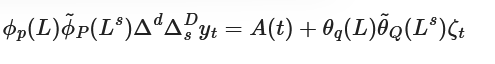

waar:
p= Autoregressive (AR) order.\
d= Integrated (I) order.\
q= Moving Average (MA) order.\
P= Seasonal AR order.\
D= Seasonal I order.\
Q= Seasonal MA order.\
S= Seasonal period.

De optimale order is te vinden met behulp van PACF of ACF 



(-0.5, 0.5)

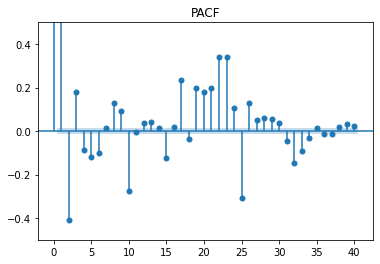

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

plot_pacf(train["cnt"], lags = 40, method = "ywm")
plt.title("PACF")
plt.ylim([-0.5, 0.5])

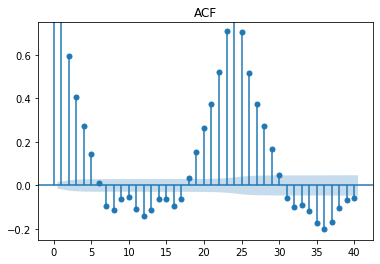

In [69]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(train["cnt"], lags=40)
plt.title("ACF")
plt.ylim([-0.25, 0.75])
plt.show()

Om een SARIMA(X) model goed te kunnen trainen is het belangrijk om naar de PACF en ACF waardes te kijken. Er wordt naar deze waardes gekeken om er achter te komen hoeveel lags er toegevoegd kunnen worden. Ook worden ze gebruikt om het SARIMA model te trainen. Er zijn een aantal verschillen tussen de twee functies.
- PACF (Partial Auto Correlation Function):
 - Bij een Partial Auto Correlation Function wordt er gekeken naar de waardes die een totaal van 1 hebben.
- ACF (Auto Correlation Function): 
 - Bij een Auto Correlation Function wordt er gekeken naar het punt er voor. Bijvoorbeeld -1, -2. Dit is totaal dus niet 1.
 
De autocorrelatiefunctie (ACF) en de gedeeltelijke autocorrelatiefunctie (PACF) vertonen een sinusvormig of golvend patroon. Dit suggereert de aanwezigheid van seizoensgebondenheid in de tijdreeks. De PACF heeft een duidelijke piek bij 24 wat een Seasonal period (S) van 24 aangeeft en een Seasonal MA order (Q) van 1.

Er is ook een daling te zien in de autocorrelatie na de seizoensgebonden lag, wat aangeeft dat de seizoensgebonden MA-term effectief is in het modelleren van de seizoensgebonden afhankelijkheid.

In de PACF plot is significante piek op het lag 1. Dit suggereert dat er een sterke partiële autocorrelatie is met het lag 1, wat kan duiden op de aanwezigheid van een autoregressief patroon (P=1).
(ChatGPT, 2023 ,SARIMAX model evaluation)

In [70]:
## uitkomst param grid
my_order = (1,1,0)
my_seasonal_order = (1, 1, 1, 24)

In [71]:
#splitsing in train en test set
train_data = sarima_train[:-24*3*7]
train_data = train_data['cnt']
test_data = sarima_train[-24*3*7:]
test_data = test_data['cnt']

In [72]:
# SARIMAX op de train_set
model = SARIMAX(train_data, order=my_order, seasonal_order = my_seasonal_order)
mf = model.fit(disp=True)

# get the predictions 
y_pred = mf.forecast(len(test_data))
y_pred = pd.Series(y_pred, index=test_data.index)

# scores
MSE = mean_squared_error(test_data, y_pred)
RMSE = MSE**0.5
R2 = r2_score(test_data, y_pred)
MAE = mean_absolute_error(test_data, y_pred)
print('R2:',R2,
        '\nMAE:', MAE,
        '\nMSE:',MSE,
        '\nRMSE:',RMSE)

R2: 0.02096084258746167 
MAE: 140.72118536905091 
MSE: 31824.098187928474 
RMSE: 178.39310016906055


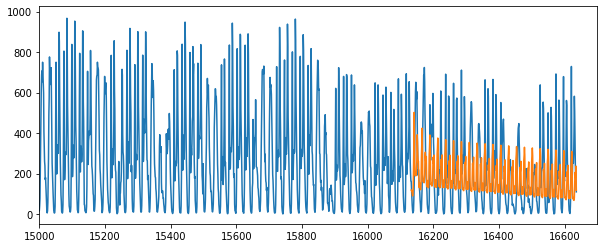

In [73]:
# plot de voorspelling
plt.figure(figsize=(10,4))
plt.plot(sarima_train['cnt'])
plt.plot(y_pred)
plt.xlim(15000, 16700)
plt.show()

16637     52.135795
16638     23.218708
16639     15.587296
16640      5.237450
16641     -0.368700
            ...    
17088    271.795878
17089    174.907579
17090    114.278328
17091     86.808158
17092     32.924108
Name: predicted_mean, Length: 456, dtype: float64

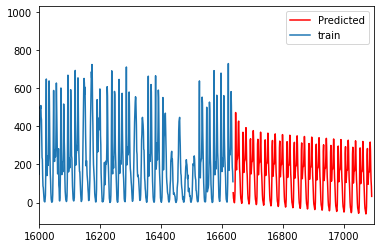

In [74]:
# SARIMAX voor de hele dataset
model = SARIMAX(sarima_train['cnt'], order=my_order, seasonal_order = my_seasonal_order)
result = model.fit(disp=True)

# voorspelling op df_test
forecast_steps_test = len(sarima_test) 
forecast_test = result.get_forecast(steps=forecast_steps_test)
sm_pred = forecast_test.predicted_mean
display(sm_pred)

# plot de voorspelling
plt.plot(sm_pred.index, sm_pred, label='Predicted', color='red')
plt.plot(sarima_train['cnt'],label='train')
plt.legend()
plt.xlim(16000, 17100)
plt.show()

**SARIMA Nadeel:**\
Bij langere termijn voorspellingen stapeld de onzekerheid op. Kleine fouten in de voorspellingen op korte termijn kunnen zich opstapelen en leiden tot aanzienlijke afwijkingen op langere termijn. Daarom is het beter om SARIMA  te gebruiken voor korte termijn voorspellingen in de Toekomst.

### Prophet

Prophet is een voorspellingsmodel voor tijdreeksen, ontwikkeld door Facebook. Het houd rekening mee met trendcomponenten, seizoenspatronen en feestdagen. Het model is automatisch en betrouwbaar, zelfs met rommelige gegevens, ontbrekende informatie of grote veranderingen in de gegevensreeks. Het werkt automatisch en biedt aanpasbare parameters. Prophet is beschikbaar in zowel R als Python en levert snel en accuraat voorspellingen op. (Prophet, n.d.)

1. *changepoint_prior_scale:* Deze parameter beïnvloedt de flexibiliteit van de trend in het model. Een te kleine waarde kan leiden tot onderfitting van de trend, terwijl een te grote waarde kan leiden tot overfitting. De standaardwaarde van 0.05 werkt goed voor veel tijdreeksen, maar kan worden aangepast binnen het bereik van [0.001, 0.5].

2. *seasonality_prior_scale:* Deze parameter controleert de flexibiliteit van de seizoenspatronen in het model. Een grote waarde staat toe dat de seizoensinvloeden grote schommelingen volgen, terwijl een kleine waarde deze invloeden beperkt. De standaardwaarde is 10, en aanpassingen kunnen worden gemaakt binnen het bereik van [0.01, 10].

3. *holidays_prior_scale:* Dit regelt de flexibiliteit om feesteffecten in het model op te nemen. Het default is 10.0, en aanpassingen kunnen worden gemaakt binnen het bereik van [0.01, 10].

4. *seasonality_mode:* Deze parameter bepaalt of de seizoenspatronen in het model worden beschouwd als 'additief' of 'multiplicatief'. Standaard is het 'additief', maar voor sommige bedrijfstijdreeksen kan 'multiplicatieve' seizoensinvloeden meer geschikt zijn. Het kan worden aangepast op basis van de aard van de tijdreeksdata. (“Diagnostics,” 2023)


Uit de gridsearch zijn de volgende parameters gekomen:

    param grid:
        {'changepoint_prior_scale': 0.001,
         'seasonality_prior_scale': 1.0,
         'seasonality_mode : multiplicative}

In [75]:
from prophet import Prophet
y_train3 = y.reset_index()
y_train3.rename(columns={'date_hour': 'ds', 'cnt': 'y'}, inplace=True)


profeet = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 0.1, seasonality_mode = 'multiplicative')
profeet.fit(y_train3)
future = profeet.make_future_dataframe(periods=len(df_test))
forecast = profeet.predict(future)

prophet_pred_test = forecast['yhat'][-len(y_test):].values

rmse = np.sqrt(np.mean((prophet_pred_test - y_test) **2))
print(f" RMSE: {rmse}")

16:47:35 - cmdstanpy - INFO - Chain [1] start processing
16:47:37 - cmdstanpy - INFO - Chain [1] done processing


 RMSE: 180.1578698392459


In [76]:
prophet_pred = forecast['yhat'][-len(df_test):].values

### XGBoost

XGBoost, is een krachtige machine learning-bibliotheek voor regressie, classificatie en ranking. Het maakt gebruik van ensemble learning, met name Gradient Boosting Decision Trees (GBDT), waarbij zwakke modellen iteratief worden toegevoegd om een sterker model te creëren. XGBoost is schaalbaar en efficiënt, gebouwd om de prestaties van machine learning-modellen te verbeteren. (What Is XGBoost?, n.d.)


1. *Learning Rate:*
   -  Het beïnvloedt de mate waarin het model leert van nieuwe bomen.
   -  Hoe hoger de leersnelheid, hoe sneller het model leert. Maar een te hoge leersnelheid kan leiden tot overfitting.

2. *Max Depth:*
   - Het controleert de depth elke beslissingsboom kan groeien.
   - Een hogere maximale diepte staat toe dat elke tree complexere patronen leert, maar kan ook leiden tot overfitting als het te hoog is.

3. *N Estimators:*
   - Het bepaalt het totale aantal "beslissingsbomen" in het model.
   - Hoe hoger het aantal trees, hoe complexer het model. Te veel bomen kunnen echter leiden tot overfitting.

4. *Subsample:*
   - Het geeft aan welk deel van de trainingsdata wordt gebruikt voor het passen van elke afzonderlijke tree.
   - Een lagere subsample voorkomt overfitting door elke tree op een kleiner deel van de gegevens te trainen. Maar te laag kan de diversiteit verminderen. (XGBoost Parameters — Xgboost 2.0.2 Documentation, n.d.)

5. *Colsample_bytree:*
    - Het geeft aan welk deel van de features (kolommen) wordt gebruikt bij het passen van elke beslissingsboom.
    - Hoe hoger de waarde, hoe meer features elke boom zal gebruiken. Een lagere waarde bevordert diversiteit tussen bomen en kan overfitting verminderen. (XGBoost Parameters — Xgboost 2.0.2 Documentation, n.d.)

Uit de gridsearch zijn de volgende parameters gekomen:

    param grid:
    {'colsample_bytree': 0.8,
     'learning_rate': 0.1,
     'max_depth' = 7,
     'n_estimators': 200,
     'subsample': 0.5}

De default van de parameter learning_rate is 0.1 dus deze specificeren wij niet in het model.

In [77]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(colsample_bytree = 0.8, max_depth = 7, n_estimators = 200, subsample = 0.5)
train_test_model(xgb_model)

R2: 0.831873549520429 
MAE: 51.37290520723614 
MSE: 5465.024179615351 
RMSE: 73.92580185304284


In [78]:
xgb_pred = xgb_model.predict(df_test)

### Hybride model

Zoals de naam al aangeeft is een hybride model een combinatie of kruising tussen twee (of meer) modellen. Het trainen van een hybride model wordt gedaan in een aantal stappen. Zo wordt er eerst een model getraind op de manier dat je gewend bent. In ons voorbeeld trainen wij eerst een Random Forest model. Hiervoor gebruiken wij de zelfde parameters als bij het trainen van ons losse Random Forest model. Hierna trainen wij een Gradient Boosting model. Tijdens het trainen van het Gradient Boosting model wordt er gebruik gemaakt van de uitkomsten van de voorspellingen van het Random Forest model. Ook wordt voor de voorspellingen van het Gradient Boosting model gebruik gemaakt van de voorspellingen met het Random Forest model. 

Dit model zou betere voorspellingen moeten geven, omdat het model uitgaat van de voorspellingen van twee (of meer) modellen. Een punt wat een Hybride model anders maakt dan andere ensemble modellen is het feit dat een Hybride model alleen modellen kunnen gebruiken die hetzelfde probleem willen voorspellen. 

In conclussie gebruik je dus meerdere modellen om tot voorspellingen te komen. Het ene model wordt gebruikt om voor het andere model voorspellingen te doen. Dit werkt anders bij andere modellen waar wij bijvoorbeeld zien dat er meerdere modellen worden gebruikt om tot één antwoord te komen. Dit gebeurt dan om het gemiddelde te pakken tijdens de training. Bij een Hybride model wordt er eerst een model getraind en dat model wordt weer gebruikt om de definitieve voorspellingen op te doen. Dit gaat dus in meerdere stappen. (Wikipedia contributors, 2023)

Voor het hybride model hebben wij geen losse parameter tuning toegepast. Dit komt, omdat wij gebruik maken van twee modellen die al eerder zijn gebruikt om voorspellingen mee te doen. Voor deze modellen hebben wij wel een parameter tuning gedaan en deze hebben wij gebruikt in het hybride model.

In [79]:
import xgboost as xgb
xgb_model1 = xgb.XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 7, n_estimators = 200, subsample = 0.5)
random_forest1 = RandomForestRegressor(random_state = 27, max_depth = 17, min_samples_split = 9)

xgb_model1.fit(X_train, y_train)
train_predict = xgb_model1.predict(X_train)

y_train_res = y_train.values.ravel() - train_predict

random_forest1.fit(X_train2, y_train_res)
train_predictions_total = random_forest1.predict(X_train2) + train_predict

In [80]:
rmse = np.sqrt(np.mean((train_predictions_total - y_train) ** 2))
print(f'Hybride model Root Mean Squared Error: {rmse}')

Hybride model Root Mean Squared Error: 18.850399828194526


In [81]:
train_predict = xgb_model1.predict(df_test)
hybrid_pred = random_forest1.predict(df_test2) + train_predict

Met behulp van de code uit de laatste machine learning les hebben wij dit model kunnen trainen.

### Pushen Kaggle

In [82]:
def push_dataframe(p_id_values, predictions_values, push=True, csv_file_path=None):
    """
    Creëert een DataFrame met kolommen 'p_id' en 'predictions' en slaat het op naar een CSV-bestand (optioneel).

    Args:
        p_id_values (list): Een lijst met waarden voor de 'p_id'-kolom.
        predictions_values (list): Een lijst met waarden voor de 'predictions'-kolom.
        push (bool): Een boolean die aangeeft of het DataFrame moet worden opgeslagen naar een CSV-bestand.
        csv_file_path (str): Het pad naar het CSV-bestand waarin het DataFrame moet worden opgeslagen (alleen nodig als push=True).

    Returns:
        pd.DataFrame: Een DataFrame met de opgegeven kolommen.
    """
    
    # Flatten the predictions_values array if it's 2D
    if len(predictions_values.shape) > 1:
        predictions_values = predictions_values.flatten()
        
    data = {'date_hour': p_id_values, 'cnt': predictions_values}
    df = pd.DataFrame(data)
    
    if push and csv_file_path:
        df.to_csv(csv_file_path, index=False)
        print(f"CSV file '{csv_file_path}' has been created.")
    
    return df

Deze functie komt uit ons eerste portfolio.

In [87]:
csv_file_path = r'D:\Jaspe\ADS_Ai_2\Machine Learning\ML_Portefolio\Voorspel verhuuraantallen 2023\Kaggle submissions\Sarima_01.csv'

#parameters
id_values = test.index # niet veranderen
predictions_values = sm_pred #predictions van model

# push functie toepassen
push_dataframe(id_values, predictions_values, push=True, csv_file_path=csv_file_path)

CSV file 'D:\Jaspe\ADS_Ai_2\Machine Learning\ML_Portefolio\Voorspel verhuuraantallen 2023\Kaggle submissions\Sarima_01.csv' has been created.


,date_hour,cnt
16637,2012-12-01 00:00:00,52.135795
16638,2012-12-01 01:00:00,23.218708
16639,2012-12-01 02:00:00,15.587296
16640,2012-12-01 03:00:00,5.237450
16641,2012-12-01 04:00:00,-0.368700
...,...,...
17088,2012-12-19 19:00:00,271.795878
17089,2012-12-19 20:00:00,174.907579
17090,2012-12-19 21:00:00,114.278328
17091,2012-12-19 22:00:00,86.808158


### Bevindingen

##### Samenvatting van de uitkomsten van de modellen.

- Een beknopt overzicht van de resultaten

**Lineaire Regressie:**
RMSE: 137.00

**Random Forest:**
RMSE: 87.78

**Gradient Boosting:**
RMSE: 81.77

**Decision Tree:**
RMSE: 95.44

**Prophet:**
RMSE: 180.16

**XGBoost:**
RMSE: 71.62

**Hybride Model:**
RMSE: 18.98

Het hybride model lijkt betere voorspellingen te doen, met de laagste RMSE-waarde van 18.98. Gradient Boosting en XGBoost presteren ook goed, terwijl Prophet en Lineaire Regressie hogere RMSE-waarden hebben, wat betekent dat zij minder nauwkeurige voorspellingen doen.

- Welk model presteert het beste? Bij welke parameters?
De hybride model presteert het beste met een score van RMSE = 18.98. Dit gebruikt twee modellen (XGBoosting en RandomForest) waardoor er veel parameters in totaal zijn.
  
  
        XGBoosting:
            colsample_bytree = 0.8,
            learning_rate = 0.1,
            max_depth = 7,
            n_estimators = 200,
            subsample = 0.5
            
        RandomForest:
            random_state = 27,
            max_depth = 17,
            min_samples_split = 9

- Toon je scores op kaggle en laat zien wat de resultaten waren van je verbeteringen op de score van kaggle.

### Conclusie en aanbevelingen

##### Welke features hebben het meeste invloed op de voorspellingen?
   
   - Temperatuur (`temp`): Een hogere temperatuur correleert.
   - Gevoelstemperatuur (`atemp`): Een hogere gevoelstemperatuur correleert positief.
   - Tijdstip van de dag (`hour_of_day`): De uren van de dagen hebben invloed op de aantal verhuringen.
   - Jaar (`year`): Een recent jaar correleert positief met een groter aantal verhuurde fietsen.

In onze situatie is de Pearson-correlatiecoëfficiënthet handigst. We willen namelijk kijken of er een duidelijk verband bestaat tussen het aantal verhuurde fietsen en andere getallen in onze dataset. De Pearson-correlatiecoëfficiënt is goed omdat deze specifiek meet hoe sterk en in welke richting twee getallen met elkaar samenhangen. In ons geval vermoeden we dat als het aantal verhuurde fietsen stijgt of daalt, andere metingen dat ook zullen doen, en dit kan worden weergegeven door een rechte lijn.

##### In hoeverre sluit dit aan op de EDA?
Wij zien terug in de EDA dat deze 4 features echt invloed hadden op de aantal verhuringen. 
Wij zagen in stijgende lijn in de visualisaties van de temperaturen. Daarin zagen wij, wanneer de temperatuur stijgt, werden er meer fietsen verhuurd.
Ook op tijdstip van dag zagen we dat het veel invloed heeft. Wij zagen dat rond de spitsuren de verhuringen echt heel hard steeg. 
Voor jaar zagen we dat in het ene jaar veel meer fietsen werden verhuurd dan in het andere jaar. Dus dit punt sluit ook meteen aan op de EDA.

##### Welk advies kun je op basis hiervan geven aan de verhuurder?
Wij adviseren om tijdens een warme periode en tijdens de spitsuren om nog meer fietsen beschikbaar te zetten. Hiermee bedoelen wij dat de verhuurder meer fietsen op een locatie kan zetten en meer plekken beschikbaar moet stellen waar mensen een fiets kunnen verhuren. Hierdoor kunnen wij verwachten er nog meer fietsen worden verhuurd.


##### Welk model zou je adviseren aan de verhuurder? Waarom? Is dit per definitie het model met de beste voorspellingen of zijn er ook andere overwegingen? Zo ja, welke?
Omdat wij de RMSE gebruiken tijdens het modelleren adviseren wij om de hybride model te gebruiken. Dit model overfit niet en geeft ook nog een prachtige scoren op de test sets. RMSE geeft een begrijpelijke maat voor de nauwkeurigheid van voorspellingsmodellen. Het benadrukt grote fouten, maakt modellen vergelijkbaar en is daardoor makkelijk te begrijpen voor de verhuurder.


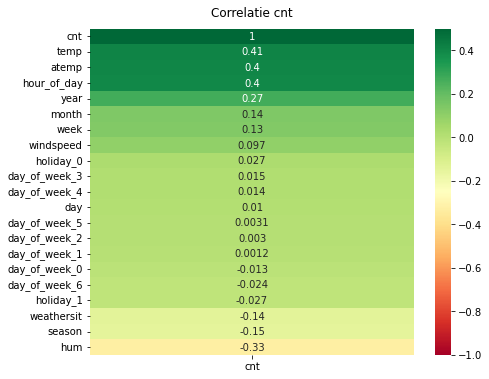

In [84]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(dfNew.corr(method='pearson')[['cnt']].sort_values(by='cnt', ascending=False),
                       vmin=-1, vmax=0.5, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie cnt', fontdict={'fontsize': 12}, pad=12)
 
plt.show()

### Literatuurlijst
**Linear Regression:**
- What is Linear Regression?- Spiceworks - Spiceworks. (2023, April 3). Spiceworks. https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-linear-regression/

- Muniraj, P. (2022, February 25). Loss functions to evaluate Regression Models - Analytics Vidhya - Medium. Medium. https://medium.com/analytics-vidhya/loss-functions-to-evaluate-regression-models-8dac47e327e2

- How do you explain the impact of regularization on the bias-variance trade-off in linear regression? (n.d.). https://www.linkedin.com/advice/0/how-do-you-explain-impact-regularization-bias-variance

**Random Forest:**
- ChatGPT, 2023, Random Forest Regressor Formula. https://chat.openai.com/share/97f92d1a-0bbb-4aef-9269-be6fd4be7234

- AMO. (2022, 4 februari). Het principe van de werking van Random Forest | AMO-PB Icastat. AMO-PB Icastat | advies- en ingenieursbureau modellering, optimalisatie en statistiek. https://www.amo-nl.com/het-principe-van-de-werking-van-random-forest/

**GradientBoosting:**
- Munagala, R. (2021, 16 maart). Gradient boost for regression explained. Numpy Ninja. https://www.numpyninja.com/post/gradient-boost-for-regression-explained

**Decision Tree:**
- WallStreetMojo, 2023. Decision Tree. https://www.wallstreetmojo.com/decision-tree/

**Sarima**
- statsmodels.tsa.statespace.sarimax.SARIMAX - statsmodels 0.15.0 (+73). (n.d.). https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
- ritvikmath. (2020, May 20). Coding the SARIMA model : Time Series talk [Video]. YouTube. https://www.youtube.com/watch?v=Al8m6K_stfA
- ChatGPT, 2023 ,SARIMAX model evaluation, https://chat.openai.com/share/cf8b2fe4-c450-42df-938f-4552c836abbf

**XGBoost:**
- What is XGBoost? (n.d.). NVIDIA Data Science Glossary. https://www.nvidia.com/en-us/glossary/data-science/xgboost/
- XGBoost Parameters — xgboost 2.0.2 documentation. (n.d.). https://xgboost.readthedocs.io/en/stable/parameter.html

**Prophet:**
- Prophet. (n.d.). Prophet. https://facebook.github.io/prophet/
- Diagnostics. (2023, October 18). Prophet. https://facebook.github.io/prophet/docs/diagnostics.html
- (ChatGPT, Gridseach Prophet, 2023https://chat.openai.com/share/3c4d77ed-f981-4b7a-8b62-2f5281cf435f)

**Hybride Model:**
- Wikipedia contributors. (2023, 3 februari). Hybrid algorithm. Wikipedia. https://en.wikipedia.org/wiki/Hybrid_algorithm